Supervised ML models:
                 Model  Accuracy  Precision  Recall     F1
0  Logistic Regression     0.885      0.903   0.875  0.889
1                  KNN     0.852      0.871   0.844  0.857
2        Decision Tree     0.820      0.889   0.750  0.814
3        Random Forest     0.869      0.875   0.875  0.875


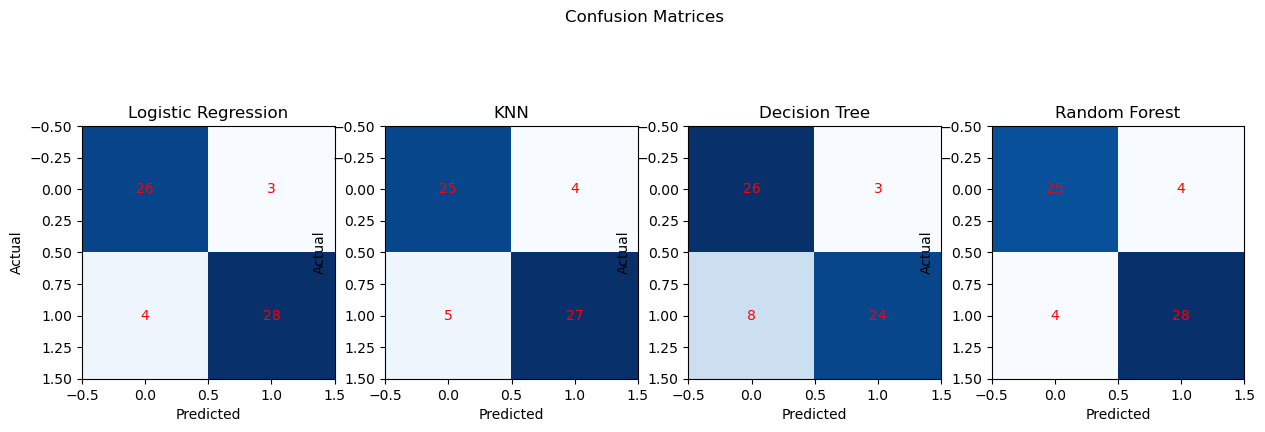

    Feature  Importance
8   oldpeak       0.104
20     ca_0       0.095
27   thal_2       0.083
6   thalach       0.083
13     cp_0       0.072


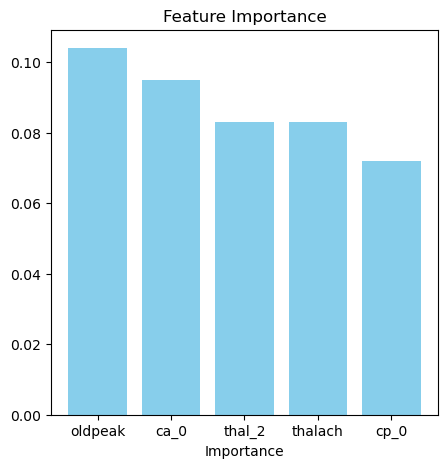

Predicted Risk and Risk Levels :
      Actual  Predicted Risk (%) RiskLevel
179       0                10.0       Low
228       0                62.0    Medium
111       1                46.0    Medium
246       0                 9.0       Low
60        1                82.0      High
..      ...                 ...       ...
249       0                36.0    Medium
104       1                95.0      High
300       0                10.0       Low
193       0                 1.0       Low
184       0                15.0       Low

[61 rows x 3 columns]
The Risk Summary :
  Risk Level  Total People
0        Low            24
1     Medium            15
2       High            22


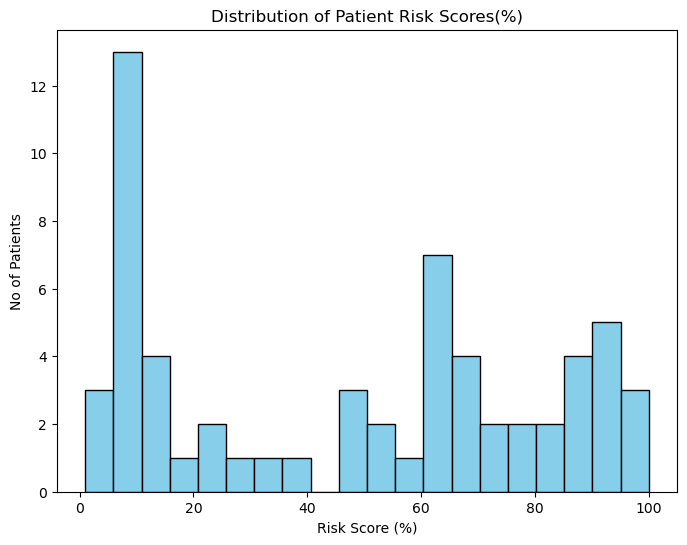

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import dataframe_image as dfi

df = pd.read_csv("heart-disease.csv")

#Feature Engineering
# 1. age_range : (29-44) , (45,59) , (60,77).
bins = [28 , 45 , 60 , 77]
labels = ['Young' , 'Middle_Aged' , 'Senior']
df['age_group'] = pd.cut(df['age'] , bins = bins , labels = labels)
df = pd.get_dummies(df, columns = ['age_group'] , drop_first = False , dtype = int)

# 2. Age * Cholesterol
df['age_chol_interaction'] = df['age'] * df['chol']

#One-hot encode
categorical_features = ['cp' , 'slope' , 'ca' , 'thal']
df = pd.get_dummies(df, columns = categorical_features , drop_first = False , dtype = int)

X = df.drop(columns = 'target')
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

#Scale numeric features
numeric_features = ['age','trestbps','chol','thalach','oldpeak','age_chol_interaction']
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# models:
print('Supervised ML models:')
models = {"Logistic Regression" : LogisticRegression(max_iter = 1000 , random_state = 42),
          "KNN" : KNeighborsClassifier(n_neighbors = 5),
          "Decision Tree" : DecisionTreeClassifier(random_state = 42),
          "Random Forest" : RandomForestClassifier(n_estimators = 100 , random_state = 42)
         }
results = []
for name , model in models.items():
    model.fit(X_train , y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model" :name,
        "Accuracy" : round(accuracy_score(y_test , y_pred),3),
        "Precision" : round(precision_score(y_test , y_pred),3),
        "Recall" : round(recall_score(y_test , y_pred),3),
        "F1" : round(f1_score(y_test , y_pred),3)
    })
results_df = pd.DataFrame(results, columns = ["Model","Accuracy","Precision","Recall","F1"])
print(results_df)

fig, axes = plt.subplots(1, 4, figsize=(15,5))
for ax, (name, model) in zip(axes,models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    im = ax.imshow(cm, cmap='Blues') 
    ax.set_title(name)  
    ax.set_xlabel("Predicted")  
    ax.set_ylabel("Actual")  
    for i in range(cm.shape[0]):  
        for j in range(cm.shape[1]):  
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

fig.suptitle("Confusion Matrices")
plt.show()

#feature importance
importances = model.feature_importances_
feature_names = X_train.columns

df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
df_importance = df_importance.sort_values(by='Importance', ascending=False).head(5)
df_importance['Importance'] = df_importance['Importance'].round(3)
print(df_importance)

plt.figure(figsize=(5,5))
plt.bar(df_importance['Feature'], df_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

#Risk score
rf = models["Random Forest"]
risk_scores = rf.predict_proba(X_test)[:,1] * 100
risk_df = pd.DataFrame({'Actual': y_test, 
                        'Predicted Risk (%)': risk_scores
                       })

risk_df['RiskLevel'] = pd.cut(risk_df['Predicted Risk (%)'], bins=[0,33,66,100], labels=['Low','Medium','High'])
print("Predicted Risk and Risk Levels :\n", risk_df)

# risk summary
summary_df = risk_df['RiskLevel'].value_counts().reindex(['Low','Medium','High']).reset_index()
summary_df.columns = ['Risk Level', 'Total People']
print('The Risk Summary :')
print(summary_df)

plt.figure(figsize=(8,6))
plt.hist(risk_df['Predicted Risk (%)'], bins = 20, color='skyblue' , edgecolor = 'black')
plt.xlabel('Risk Score (%)')
plt.ylabel('No of Patients')
plt.title('Distribution of Patient Risk Scores(%)')
plt.show()